In [68]:
import mdtraj as md
import numpy as np
from pymol import cmd
from pymol import stored
import matplotlib.pyplot as plt
import itertools
import warnings
import multiprocessing
from tqdm import tqdm
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
import pickle
import pandas as pd
import glob

In [69]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

os.environ["CUDA_VISIBLE_DEVICES"]="3"


In [70]:
from scipy import stats
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
from regression_enrichment_surface import regression_enrichment_surface as rds

In [71]:
def save_pocket(pdb, sdf, name):
    cmd.reinitialize()
    cmd.load(pdb)
    cmd.load(sdf, "LIG")
    cmd.select("POCK","br. LIG around 4")
    stored.idx = 0
    cmd.iterate("POCK and n. CA", expression="stored.idx+=1")
    cmd.save(name, "POCK")
    return stored.idx

In [110]:
element_charge = {"H": +1, "I":-1,
           "N": -3,
           "P":-3,
           "C": +4,
           "O":-2,
           "F": -1,
           "S": -2,
           "Li": +1,
           "Cl": -1,
           "Br": -1}
element_radius = {"H": 1.20, "I": 1.98,
           "N": 1.55 ,
           "P":1.95,
           "C": 1.70,
           "O":1.52,
           "F": 1.47,
           "S":1.80,
           "Li": 1.82,
           "Cl": 1.75,
           "Br": 1.85}
aa_hscale = {
"ALA":  0.620,
"ARG": -2.530,
"ASN": -0.780,
"ASP": -0.900,
"CYS":  0.290,
"GLN": -0.850,
"GLU": -0.740,
"GLY":  0.480,
"HIS": -0.400,
"ILE":  1.380,
"LEU":  1.060,
"LYS": -1.500,
"MET":  0.640,
"PHE":  1.190,
"PRO":  0.120,
"SER": -0.180,
"THR": -0.050,
"TRP":  0.810,
"TYR":  0.260,
"VAL":  1.080}

element_charge = {"H": +1, "I":-1,
           "N": -3,
           "P":-3,
           "C": +4,
           "O":-2,
           "F": -1,
           "S": -2,
           "Li": +1,
           "Cl": -1,
           "Br": -1}
atomic_number = {"H": 1, "I":53,
           "N": 7,
           "P":15,
           "C": 6,
           "O":8,
           "F": 9,
           "S": 16,
           "Li": 3,
           "Cl": 17,
           "Br": 35}

In [131]:
def get_coulomb(i,j,z_i,z_j,r):
    if i==j:
        return 0.5*z_i**2.4
    else:
        return z_i*z_j/r

def get_e_map(t,sdf_state, pqr, grid, d_matrix):
    pocket = list(t.topology.residues)
    indices =  [int(str(residue)[3:]) for residue in t.topology.residues]
    # open the pqr and iterate through lines
    pqr = open(pqr)
    lines = pqr.readlines()
    data = []

    # discard lines that do not have the residue number
    for l in lines:
        split = l.split(' ')
        split = list(filter(lambda x: x != '', split))
        if split[0] == 'TER':
            break
        res = split[4]
        if int(res) in indices:
            # collect all x,y,charge, radius values
            data.append([float(split[5]), float(split[6]), float(split[8]), float(split[9])])
    data = np.asarray(data)

    # initialize 2D array
    e_map = np.zeros([grid,grid])
    
    for i range(e_map.shape[0]):
        
    x_cell = (np.max(data[:,0]) - np.min(data[:,0]))/grid
    y_cell = (np.max(data[:,1]) - np.min(data[:,1]))/grid
    x_min = np.min(data[:,0])
    y_min = np.min(data[:,1])
    x_axis = [x_min+x_cell*i for i in range(grid)]
    y_axis = [y_min+y_cell*j for j in range(grid)]

    # place (x,y) from file into appropriate grid point
    for val in range(data.shape[0]):
        d = data[val]
        x_value = d[0]
        y_value=d[1]
        charge = d[2]
        radius = d[3]

        # naive "box" charge instead of point charge
        # also assuming constant charge rather than 1/r^2 drop off
        i_min = (int)(np.floor((x_value-x_min-radius)/x_cell))
        i_max = (int)(np.floor((x_value-x_min+radius)/x_cell))
        j_min = (int)(np.floor((y_value-y_min-radius)/y_cell))
        j_max = (int)(np.floor((y_value-y_min+radius)/y_cell))

        if i_min <0:
            i_min=0
        if j_min <0:
            j_min=0
        if i_max>=grid:
            i_max=grid-1
        if j_max>=grid:
            j_max=grid-1

        if i_min>i_max:
            print("smoething went wrot=ng")
            break
        if j_min>j_max:
            print("something went wrong")

        e_map[i_min:i_max,j_min:j_max] += charge
        
    # for each atom in the ligand add in ionic charge according to ionic radius
    lines = sdf_state.split('\n')
    lig = find_end(lines[4:])
    lig = list(filter(lambda x: 'H' not in x, lig))
    l_map = np.zeros([len(lig),len(lig)])

#     for l in lig:
#         split = l.split(' ')
#         split = list(filter(lambda x: x != '', split))
#         x_value = (float)(split[0])
#         y_value=(float)(split[1])
#         atom = split[3]
#         charge = element_charge[atom]
#         radius = element_radius[atom]

#         # naive "box" charge instead of point charge
#         # also assuming constant charge rather than 1/r^2 drop off
#         i_min = (int)(np.floor((x_value-x_min-radius)/x_cell))
#         i_max = (int)(np.floor((x_value-x_min+radius)/x_cell))
#         j_min = (int)(np.floor((y_value-y_min-radius)/y_cell))
#         j_max = (int)(np.floor((y_value-y_min+radius)/y_cell))

#         if i_min <0:
#             i_min=0
#         if j_min <0:
#             j_min=0
#         if i_max>=grid:
#             i_max=grid-1
#         if j_max>=grid:
#             j_max=grid-1

#         if i_min>i_max:
#             print("smoething went wrot=ng")
#             break
#         if j_min>j_max:
#             print("something went wrong")

#         l_map[i_min:i_max,j_min:j_max] += charge

    for l in lig:
        split = l.split(' ')
        split = list(filter(lambda x: x != '', split))
        x_value = (float)(split[0])
        y_value=(float)(split[1])
        atom = split[3]
        charge = element_charge[atom]
        radius = element_radius[atom]

    l_map = cv2.resize(l_map, dsize=(grid,grid), interpolation=cv2.INTER_CUBIC)        
    return e_map, l_map

In [132]:
# convert files into list of strings
# for the protein pdb and ligand sdf 
# (states are separated by $$$$)
def stringify(sdf, pdb, num_states):
    sdf_split = []
    with open(sdf,'r') as f:
        for key,group in itertools.groupby(f,lambda line: line.startswith('$$$$')):
          if not key:
            sdf_split.append("".join(list(group)))
          if len(sdf_split) == num_states:
            break
    
#     with open(sdf,'r') as f:
#         lines = f.readlines()
#     lines = "".join(lines)
#     test_split=lines.split("$$$$")
    
#     correct=True
#     for i,j in zip(test_split,sdf_split):
#         correct = correct and i == j
#         if i != j :
#             print(i)
#             print(j)
#             return
#     print(correct)
#     return
        
    #sdf_split = sdf_split[-num_states:]
    with open(pdb,'r') as f:
        pdb_string = f.readlines()       
    return sdf_split, "".join(pdb_string)

def find_end(lines):
    filtered_lines=[]
    for l in lines:
        split = l.split(' ')
        split = list(filter(lambda x: x != '', split))
        vals1 = (split[0])
        
        # stop when we get to the integers in the sdf
        if vals1.isdigit():
            return filtered_lines
        filtered_lines.append(l)
            
def create_pdb(sdf, pdb_string,i):
    lines = sdf.split('\n')
    #num_lines = (int)(lines[3].split(' ')[1])
    
    #lig = lines[4:4+num_lines-1]
    lig = find_end(lines[4:])
    lig = list(filter(lambda x: 'H' not in x, lig))
    lig_pdb = list(map(create_line, lig, np.arange(1,len(lig)+1)))
    f =  open("tmp{0}.pdb".format(i), 'w+')
    f.write("\n".join(lig_pdb))
    f.write("\n")
    f.write(pdb_string)
    f.close()

# Create one line in the new pdb file for one state
# and the protein
# Use the standardized pdb regex to create the correct string
def create_line(line,i):
    split = line.split(' ')
    split = list(filter(lambda x: x != '', split))
    vals1 = (float)(split[0])
    vals2 = (float)(split[1])
    vals3= (float)(split[2]) 
    atom = split[3]

    # workaround to get the atoms in the ligand to be residues in mdtraj reader
    if i >=10 :
        new_string = "{:6s}{:5d} {:^4s}{:1s}{:3s} {:1s}{:4d}{:1s}   {:8.3f}{:8.3f}{:8.3f}{:6.2f}{:6.2f}          {:>2s}{:2s}".format("HETATM",i,atom,'',"U"+str(i),'',0,'',vals1, vals2,vals3,0,0,atom,'')
    else:
        new_string = "{:6s}{:5d} {:^4s}{:1s}{:3s} {:1s}{:4d}{:1s}   {:8.3f}{:8.3f}{:8.3f}{:6.2f}{:6.2f}          {:>2s}{:2s}".format("HETATM",i,atom,'',"UN"+str(i),'',0,'',vals1, vals2,vals3,0,0,atom,'')
    return new_string

# Create the data for ML model

# First array is contact matrix
# - ----------------| ligand atoms | protein residues
# - ligand atoms    |              | 
# ------------------|--------------|-----------------
# - protein residues|              |
#
# Second array is a mask for which cells correspond to ligand x ligand (-1), 
# protein x protein (1) and ligand x protein (0)
#
# Arrays are interpolated to 64x64
def maker_w_strings(data):
    i,sdf_state, num_residues, pdb = data
    tmp_file = str(id(multiprocessing.current_process()))
    create_pdb(sdf_state,pdb,tmp_file) # create the pdb for one states
    
    # Load the file into mdtraj
    t = md.load("tmp{0}.pdb".format(tmp_file))
    pl = len(list(t.topology.residues))
    resi = np.arange(pl)
    pairs = list(itertools.product(resi, resi))
    
    # compute constacts
    matrix, l = md.compute_contacts(t, contacts=pairs, scheme="closest-heavy")
    matrix = np.array(matrix).reshape((pl,pl))
    
    aa_matrix_h = np.zeros((pl, pl))
    aa_matrix_v = np.zeros((pl, pl))
    resi_list = list(t.topology.residues)
    atom_list = list(t.topology.atoms)

    for p in range(pl):
        r = resi_list[p]
        if not str(r).startswith('U'):
            aa_matrix_v[:,p]=aa_hscale[r.name]
            aa_matrix_h[p]=aa_hscale[r.name]
        else:
            a = atom_list[p]
            aa_matrix_v[:,p] =element_charge[a.name]
            aa_matrix_h[p]=element_charge[a.name]
            
    ### generate protein-ligand mask
    mask = np.zeros((pl,pl))
    for i in range(pl-num_residues):
        for j in range(pl-num_residues):
            # ligand
            mask[i,j] = -1
            
    for i in range(pl - num_residues,pl):
        for j in range( pl - num_residues,pl):
            # protein
            mask[i,j] = 1
    e_map, l_map = get_e_map(t, sdf_state, "mol.pqr", 64, matrix)
    p_img = cv2.resize(matrix, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape(64,64,1)
    m_img = cv2.resize(mask, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape(64,64,1)
    v_img = cv2.resize(aa_matrix_v, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape(64,64,1)
    h_img = cv2.resize(aa_matrix_h, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape(64,64,1)
    

    p_contact_matrix = np.concatenate([p_img, m_img, e_map.reshape(64,64,1), l_map.reshape(64,64,1)], axis=-1)
    os.remove("tmp{0}.pdb".format(tmp_file))
    return p_contact_matrix
    

In [134]:
maps=[]
num_residues = save_pocket("april27/ADRP/ADRP_6W02_A_1_H.pdb", "april27/ADRP/adrp_adpr_A_cat_sorted_top100.sdf", "april27/ADRP/adrp_gen_pock.pdb")
print("done creating pocket")
s, pdb_string = stringify("april27/ADRP/adrp_adpr_A_cat_sorted.sdf", "april27/ADRP/adrp_gen_pock.pdb", 10000)
pdb_string = [pdb_string for x in range(len(s))]

with multiprocessing.Pool(32) as p:
    num_states = len(s)
    data = list(zip(range(num_states), s, num_residues*np.ones(num_states,dtype=int), pdb_string))
    itern = p.imap(maker_w_strings, data)
    for i,p_contact_matrix in enumerate(tqdm(itern, total=num_states)):
        maps.append(p_contact_matrix)


done creating pocket


100%|██████████| 10000/10000 [01:05<00:00, 151.60it/s]


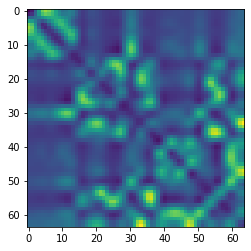

In [169]:
plt.imshow(maps[5][:,:,3])

In [145]:
images_adrp = np.stack(maps,axis=0)
print(images_adrp.shape)

(10000, 64, 64, 4)


In [144]:
df_adrp = pd.read_csv("rescore_top10k.csv")

In [177]:
data_images =[]
data_scores = []
data_images_bottom =[]
data_scores_bottom = []
files_m = glob.glob('./**/*high.matrices.npy', recursive=True)
files_s = glob.glob('./**/*.scores', recursive=True)
for m,s in zip(files_m, files_s):
    print(m,s)
#     if "bottom" not in m:
    data_images.append(np.load(m)[0:5000])
    data_scores.append(pd.read_csv(s).iloc[0:5000])
#     else:
#     data_images_bottom.append(np.load(m)[-5000:])
#     data_scores_bottom.append(pd.read_csv(s).iloc[-5000:])
    

./april27/PLPro/2/plpro_2.high.matrices.npy ./april27/PLPro/2/plpro_2.scores
./april27/PLPro/1/plpro_1.high.matrices.npy ./april27/PLPro/1/plpro_1.scores
./april27/NSP15_6w01/2/NSP15_2_6w01.high.matrices.npy ./april27/NSP15_6w01/2/NSP15_2_6w01.scores
./april27/NSP15_6w01/1/NSP15_1_6w01.high.matrices.npy ./april27/NSP15_6w01/1/NSP15_1_6w01.scores
./april27/NSP15_6vww/1/NSP15_1_6vww.high.matrices.npy ./april27/NSP15_6vww/1/NSP15_1_6vww.scores
./april27/NSP15_6vww/2/NSP15_2_6vww.high.matrices.npy ./april27/NSP15_6vww/2/NSP15_2_6vww.scores
./april27/3CLPro/1/3CLPro_1.high.matrices.npy ./april27/3CLPro/1/3CLPro_1.scores
./april27/3CLPro/2/3CLPro_2.high.matrices.npy ./april27/3CLPro/2/3CLPro_2.scores
./april27/3CLPro/3/3CLPro_3.high.matrices.npy ./april27/3CLPro/3/3CLPro_3.scores
./april27/ADRP/ADRP_6W02_A_1_H.high.matrices.npy ./april27/ADRP/ADRP_6W02_A_1_H.scores
./april27/DNMT3A/DNMT3A_chainA.high.matrices.npy ./april27/DNMT3A/DNMT3A_chainA.scores
./april27/NSUN2/NSUN2_model.high.matrices

In [178]:
X = np.vstack(data_images)
y = pd.concat(data_scores)

In [179]:
print(X.shape)
print(y)

(60000, 64, 64, 4)
      Unnamed: 0                                             SMILES  \
0              0       c1cc(cc(c1)NC(=O)NCc2ccncc2)NC(=O)c3ccc[nH]3   
1              1            c1ccc2c(c1)c3c4c(c5cnccc5c3[nH]2)CNC4=O   
2              2  Cc1c(cc(c2c1oc(c(c2=O)[O-])c3[nH]c(c[nH+]3)Cl)...   
3              3  Cc1c(cc(c2c1oc(c(c2=O)[O-])c3[nH]c(c[nH+]3)OC)...   
4              4  C[C@H]1[C@@H]2[C@H]3[C@H]4[C@@H]([C@@H]([C@@H]...   
...          ...                                                ...   
4995        4995  c1ccc(cc1)c2c[nH+]c([nH]2)CNC(=O)c3cc4cc(sc4[n...   
4996        4996   C[C@@H](C(=O)N1CCC1)Sc2nc([nH]n2)c3ccc4c(c3)CCC4   
4997        4997              c1ccc(c(c1)c2cc(n[nH]2)C(=O)NCCOCCO)O   
4998        4998      C[C@@H](c1cccs1)NC(=O)c2cc([nH]n2)c3ccc(cc3)F   
4999        4999      C[C@@H](c1cccs1)NC(=O)c2cc([nH]n2)c3ccc(cc3)F   

               TITLE                   receptor  Chemgauss4  
0         T2K-520944    april27/PLPro/2/plpro_2  -13.482728  
1   

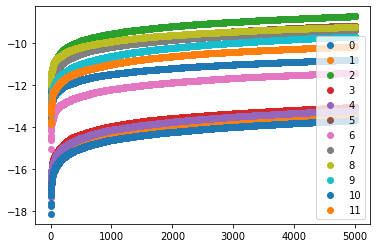

In [180]:
for i in range(12):
    plt.scatter(np.arange(5000), y['Chemgauss4'].iloc[5000*i:5000*(i+1)], label=i)
plt.legend()    

(60000, 64, 64, 2)


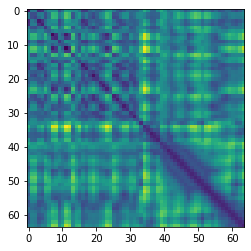

In [181]:
X_2d = X[:,:,:,0:2]
print(X_2d.shape)
plt.imshow(X_2d[0][:,:,0])

# X_2d_bottom = X_bottom[:,:,:,0:2]
# print(X_2d_bottom.shape)

In [146]:
def adapt_learning_rate(epoch):
    return 1e-3 * epoch
my_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate)

In [147]:
def r2_keras(y_true, y_pred):
    from tensorflow.keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

(10000, 64, 64, 3)
Chemgauss4


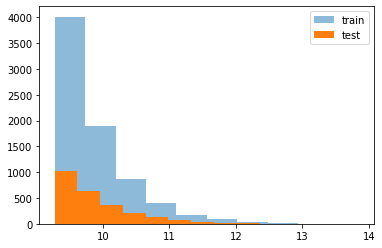

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 59, 59, 8)         872       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 57, 57, 32)        2336      
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 55, 55, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 27, 27, 32)        0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 27, 27, 32)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 23328)             0         
_________________________________________________________________
dense_65 (Dense)             (None, 64)              

7500/7500 [==============================] - 1s 138us/sample - loss: 0.0111 - mean_squared_error: 0.0111 - r2_keras: 0.2356 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_r2_keras: -0.2368
Epoch 33/50
7500/7500 [==============================] - 1s 139us/sample - loss: 0.0110 - mean_squared_error: 0.0110 - r2_keras: 0.2315 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_r2_keras: -0.1780
Epoch 34/50
7500/7500 [==============================] - 1s 138us/sample - loss: 0.0107 - mean_squared_error: 0.0107 - r2_keras: 0.2651 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_r2_keras: -0.3564
Epoch 35/50
7500/7500 [==============================] - 1s 139us/sample - loss: 0.0104 - mean_squared_error: 0.0104 - r2_keras: 0.2839 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_r2_keras: -0.3810
Epoch 36/50
7500/7500 [==============================] - 1s 136us/sample - loss: 0.0102 - mean_squared_error: 0.0102 - r2_keras: 0.2900 - val_loss: 0.0135 - val_mea

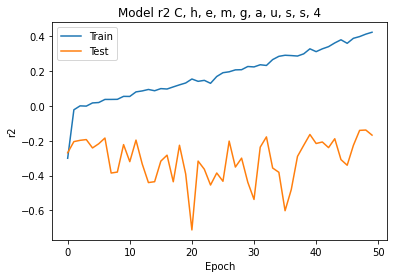

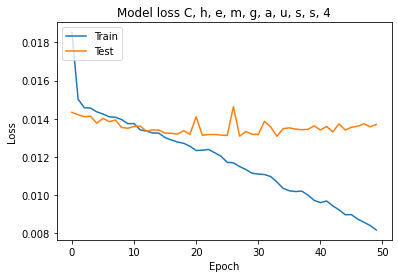

r2 0.07806315245360318
pearson (0.33535560655796404, 9.138985586748948e-67)
spearman SpearmanrResult(correlation=0.2635180626168581, pvalue=5.504176375574818e-41)
MSE actual 0.2868264853097933


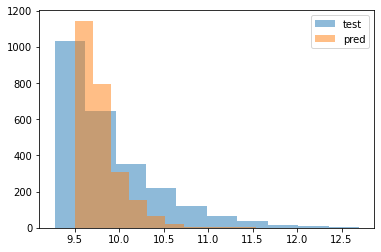

In [176]:
X_adrp = images_adrp[:,:,:,[0,1,2]]
print(X_adrp.shape)
y=df_adrp
columns = [ 'CG3:Steric', 'CG3:Clash', 'CG3:ProDesolv', 'CG3:LigDesolv',
       'CG3:LigDesolvHB', 'CG4:HB', 'Chemgauss4']
subsets = [ ['CG3:Steric', 'CG3:Clash', 'CG4:HB'], ['CG3:ProDesolv', 'CG3:LigDesolv',
       'CG3:LigDesolvHB'], ['Chemgauss4']]
total = ['Chemgauss4']
for c in total:
    print(c)
    isList = isinstance(c,list)
    df_new = y.copy(deep=True)
    scaler = MinMaxScaler()
    dock_score = np.abs(df_new[c].to_numpy())
    if isList:
        dock_score = scaler.fit_transform(np.sum(dock_score,axis=-1).reshape(-1,1))
    else:
        dock_score = scaler.fit_transform(dock_score.reshape(-1,1))
    df_new['score'] = dock_score    
    
    X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_adrp, df_new, test_size=0.25,
                                                         shuffle=True)        

    dock_score_train= y_train_top['score'].to_numpy()
    dock_score_test = y_test_top['score'].to_numpy()
    plt_train=scaler.inverse_transform(dock_score_train.reshape(-1,1))
    plt_test=scaler.inverse_transform(dock_score_test.reshape(-1,1))
        
    # plot train/test split
    plt.hist(plt_train, alpha=0.5, label='train')
    plt.hist(plt_test,alpha=1, label='test')
    plt.legend()
    plt.show()
    
    # model stuff
    dr = 0.1
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(6, 6),
                     activation='relu',
                     input_shape=(64,64,3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dr))
    model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(dr))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dr))
    model.add(Dense(1))

    model.compile(loss=tf.keras.losses.mean_squared_error,
                  optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                  metrics=['mean_squared_error', r2_keras])
    print(model.summary())
    history = model.fit(X_train_top, dock_score_train,
              batch_size=64,
              epochs=50,
              verbose=1,
              validation_data=(X_test_top, dock_score_test))
    
    # Plot training & validation loss values
    plt.plot(history.history['r2_keras'])
    plt.plot(history.history['val_r2_keras'])
    plt.title('Model r2 ' + ', '.join(c))
    plt.ylabel('r2')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss ' + ', '.join(c))
    plt.ylabel('Loss')

    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    y_pred = model.predict(X_test_top)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(dock_score_test.reshape(-1,1))

    print("r2", r2_score(y_test_inv, y_pred_inv))
    print("pearson", pearsonr(y_test_inv.flatten(),y_pred_inv.flatten()))
    print("spearman", spearmanr(y_test_inv.flatten(),y_pred_inv.flatten()))
    print("MSE actual", mean_squared_error(y_test_inv, y_pred_inv))

    plt.hist(y_test_inv, alpha=0.5, label="test")
    plt.hist(y_pred_inv,alpha=0.5, label="pred")
    plt.legend()
    plt.show()

In [ ]:
print(np.max(y_pred_inv))
print(np.max(y_test_inv))

In [66]:
top_pred = y_test_top.iloc[np.argsort(y_pred_inv.flatten())[-1000:]][['SMILES']].to_numpy()
top_true = y_test_top.iloc[np.argsort(y_test_inv.flatten())[-1000:]][['SMILES']].to_numpy()

In [67]:
check = []
for i in range(top_pred.shape[0]):
    check.append(top_pred[i] in top_true)
print(np.sum(check))

357


pearson (0.9657815168813626, 0.0)
r2 0.928013301244986
mae 0.3753450291607625
precision, recall 0.6695652173913044 0.051333333333333335
auc 0.5242592592592592


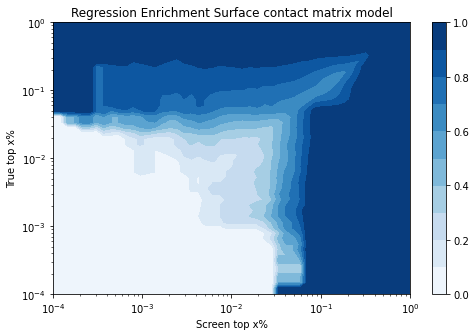

In [68]:
values = y_test_inv.flatten()
preds = y_pred_inv.flatten()
quant = np.quantile(values, 0.90)
values_bin = [0 if val < quant else 1 for val in values]
preds_bin = [0 if val < quant else 1 for val in preds]
print("pearson", stats.pearsonr(values, preds))
print("r2", r2_score(values, preds))
print("mae", mean_absolute_error(values, preds))
print("precision, recall" ,precision_score(values_bin, preds_bin), recall_score(values_bin, preds_bin))
fpr, tpr, thresholds = roc_curve(values_bin, preds_bin)
print("auc", auc(fpr, tpr))

rds_model = rds.RegressionEnrichmentSurface(percent_min=-4)
rds_model.compute(values, preds, samples=50)
rds_model.plot(title='Regression Enrichment Surface contact matrix model')